### Solve IK for `Common Rig H EmotionMocap` 

In [9]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,r2quat,rpy2R,r2rpy
import pickle

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse `scene_common_rig_h.xml`

In [10]:
xml_path = '../asset/walker/walker.xml'
# xml_path = '../asset/common_rig/scene_common_rig_v2.xml'
env = MuJoCoParserClass(name='myosuite',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

<_MjModelActuatorViews
  acc0: array([958.8])
  actadr: array([-1], dtype=int32)
  actlimited: array([0], dtype=uint8)
  actnum: array([0], dtype=int32)
  actrange: array([0., 0.])
  biasprm: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  biastype: array([0], dtype=int32)
  cranklength: array([0.])
  ctrllimited: array([1], dtype=uint8)
  ctrlrange: array([-1.,  1.])
  dynprm: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  dyntype: array([0], dtype=int32)
  forcelimited: array([0], dtype=uint8)
  forcerange: array([0., 0.])
  gainprm: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  gaintype: array([0], dtype=int32)
  gear: array([100.,   0.,   0.,   0.,   0.,   0.])
  group: array([0], dtype=int32)
  id: 0
  length0: array([0.])
  lengthrange: array([0., 0.])
  name: 'right_hip'
  trnid: array([ 3, -1], dtype=int32)
  trntype: array([0], dtype=int32)
  user: array([], dtype=float64)
>
<_MjModelActuatorViews
  acc0: array([594.96])
  actadr: array([-1], dtype=int32)
  actlimited

In [11]:
# env.open_interactive_viewer()
# env.get_p_body('femur_r')-env.get_p_body('pelvis'),env.get_p_body('femur_l')-env.get_p_body('pelvis')
# print(np.linalg.norm(env.get_p_body('pelvis')-env.get_p_body('femur_r')))
# print(np.linalg.norm(env.get_p_body('femur_r')-env.get_p_body('tibia_r')))
# print(np.linalg.norm(env.get_p_body('tibia_r')-env.get_p_body('talus_r')))
# env.model.qpos0[3:7] = [1,0,0,0]
# env.model.body_quat[:] = [1,0,0,0]
# env.open_interactive_viewer()
# env

In [12]:
def np_uv(vec):
    """
        Get unit vector
    """
    x = np.array(vec)
    return x/np.linalg.norm(x)

# Lower body only
def get_uv_dict_cmu(p):
    uv_dict = {}

    # Lower Body
    uv_dict['Hips2RightUpLeg'] = np_uv(p[27,:] - p[0,:])
    uv_dict['RightUpLeg2RightLeg'] = np_uv(p[28,:] - p[27,:])
    uv_dict['RightLeg2RightFoot'] = np_uv(p[29,:] - p[28,:])
    uv_dict['RightFoot2RightToeBase'] = np_uv(p[30,:] - p[29,:])
    uv_dict['Hips2LeftUpLeg'] = np_uv(p[33,:] - p[0,:])
    uv_dict['LeftUpLeg2LeftLeg'] = np_uv(p[34,:] - p[33,:])
    uv_dict['LeftLeg2LeftFoot'] = np_uv(p[35,:] - p[34,:])
    uv_dict['LeftFoot2LeftToeBase'] = np_uv(p[36,:] - p[35,:])
    
    # Upper Body
    # uv_dict['pelvis2torso'] = np_uv(p[9,:] - p[0,:])
    # uv_dict['torso2humerus_r'] = np_uv(p[17,:] - p[9,:])
    # uv_dict['humerus_r2radius'] = np_uv(p[18,:] - p[17,:])
    # uv_dict['radius2lunate'] = np_uv(p[19,:] - p[18,:])
    # uv_dict['torso2humerus_l'] = np_uv(p[45,:] - p[9,:])
    # uv_dict['humerus_l2radius_l'] = np_uv(p[46,:] - p[45,:])
    # uv_dict['radius_l2lunate_l'] = np_uv(p[47,:] - p[46,:])

    return uv_dict

def get_p_target_walker_cmu(p, uv_dict):
    len_rig = {}
    len_rig['root2rp'] = 0.30413812651491096
    len_rig['rp2rk'] = 0.45
    len_rig['rk2ra'] = 0.5
    len_rig['root2lp'] = 0.30413812651491096
    len_rig['lp2lk'] = 0.45
    len_rig['lk2la'] = 0.5

    p_target = {}
    p_target['right_thigh'] = p[0,:] + len_rig['root2rp'] * uv_dict['Hips2RightUpLeg']
    p_target['aux_right_leg'] = p_target['right_thigh'] + len_rig['rp2rk'] * uv_dict['RightUpLeg2RightLeg']
    p_target['aux_right_foot'] = p_target['aux_right_leg'] + len_rig['rk2ra'] * uv_dict['RightLeg2RightFoot']
    p_target['left_thigh'] = p[0,:] + len_rig['root2lp'] * uv_dict['Hips2LeftUpLeg']
    p_target['aux_left_leg'] = p_target['left_thigh'] + len_rig['lp2lk'] * uv_dict['LeftUpLeg2LeftLeg']
    p_target['aux_left_foot'] = p_target['aux_left_leg'] + len_rig['lk2la'] * uv_dict['LeftLeg2LeftFoot']
    # p_target['spine'] = p[0,:] + len_rig['root2spine'] * uv_dict['root2spine']

   
    return p_target




### Target BVH

In [13]:
with open(file='data.pickle', mode='rb') as f:
    data=pickle.load(f)

p_full = data['p']
r_full = data['R']

frame_number = 0
p = p_full[frame_number]
r = r_full[frame_number]
p[:, 1] -= p[0, 1]
uv_dict = get_uv_dict_cmu(p)
p_target = get_p_target_walker_cmu(p, uv_dict)

In [14]:
p

array([[-2.66,  0.  ,  1.73],
       [-2.66,  0.  ,  1.73],
       [-2.66,  0.  ,  1.94],
       [-2.65, -0.  ,  2.16],
       [-2.65, -0.  ,  2.16],
       [-2.7 , -0.32,  2.25],
       [-2.67, -0.34,  1.72],
       [-2.44, -0.39,  1.42],
       [-2.44, -0.39,  1.42],
       [-2.37, -0.37,  1.38],
       [-2.44, -0.39,  1.42],
       [-2.38, -0.41,  1.38],
       [-2.33, -0.42,  1.35],
       [-2.65, -0.  ,  2.16],
       [-2.72,  0.32,  2.26],
       [-2.77,  0.31,  1.74],
       [-2.71,  0.36,  1.38],
       [-2.71,  0.36,  1.38],
       [-2.66,  0.35,  1.34],
       [-2.71,  0.36,  1.38],
       [-2.7 ,  0.37,  1.33],
       [-2.69,  0.37,  1.28],
       [-2.65, -0.  ,  2.16],
       [-2.67,  0.  ,  2.32],
       [-2.67,  0.01,  2.49],
       [-2.64,  0.01,  2.65],
       [-2.66,  0.  ,  1.73],
       [-2.6 , -0.17,  1.56],
       [-2.75, -0.09,  0.87],
       [-3.17, -0.01,  0.23],
       [-2.99, -0.  ,  0.08],
       [-2.87, -0.01,  0.07],
       [-2.66,  0.  ,  1.73],
       [-2

### Set IK targets (`24` in total: `10` for body & `14` for hands)

In [15]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Walker CMU',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()

# Set which joints to control
ctrl_joint_names = env.rev_joint_names# + env.pri_joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

env.body_names
ik_body_names = ['right_thigh','aux_right_leg','aux_right_foot','left_thigh','aux_left_leg','aux_left_foot'
                #  ,'spine','neck','right_shoulder','right_elbow','right_hand','left_shoulder','left_elbow','left_hand'
                 ]

ik_target_indices = [1,2,3,5,6,7,8,9
                    #  ,11,13,17,18,19,45,46,47
                     ]

IK_Ps = [True]*len(ik_body_names)
IK_Rs = [False]*len(ik_body_names)

ik_p_trgts = []
ik_R_trgts = []

for body in ik_body_names:
    ik_p_trgts.append(p_target[body])

for i in ik_target_indices:
    ik_R_trgts.append(r[i])

### Loop

2024-01-12 13:29:39.587 python[70225:1494542] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Pressed ESC
Quitting.


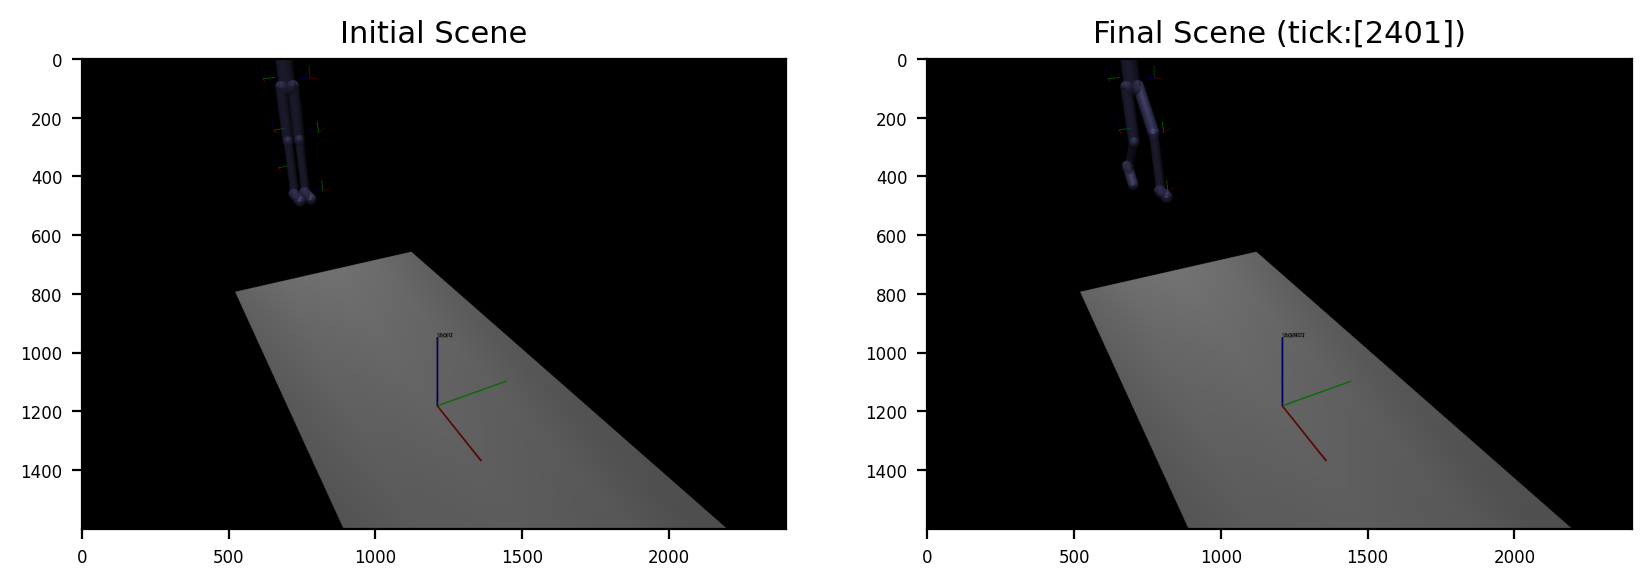

In [16]:
# Reset and loop 
q = q_ctrl_init.copy()

# # Good starting position
# init_joint_names = ['rs1','rs2','rs3','ls1','ls2','ls3','re','le']
# q_init = np.radians([70,25,-5,-70,-25,-5,35,-35])
# joint_idxs_init = [env.model.joint(jname).qposadr[0] for jname in init_joint_names]
# env.forward(q=q_init,joint_idxs=joint_idxs_init)

PERTURB_BASE_POSITION = True
if PERTURB_BASE_POSITION:
    jntadr = env.model.body('torso').jntadr[0]
    qposadr = env.model.jnt_qposadr[jntadr]
    base_pos = p[0] # modify base position
    base_pos[2] -= 1.3
    env.data.qpos[qposadr] = base_pos[2]
    env.data.qpos[qposadr+1] = base_pos[0]
    env.data.qpos[qposadr+2] = r2rpy(r[0])[1]

FIRST_FLAG = True
while env.is_viewer_alive():
    
    # Solve inverse kinematics
    J_list,ik_err_list = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        ik_p_trgt = ik_p_trgts[ik_idx]
        ik_R_trgt = ik_R_trgts[ik_idx]
        IK_P = IK_Ps[ik_idx]
        IK_R = IK_Rs[ik_idx]
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J[:,:3] = 0
        J_list.append(J)
        ik_err_list.append(ik_err)
    J_stack      = np.vstack(J_list)
    ik_err_stack = np.hstack(ik_err_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    
    # FK
    env.data.qpos[joint_idxs_fwd] = q
    q_couple = env.data.qpos.copy()

    env.forward(q=q_couple,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        env.plot_body_T(body_name='torso',PLOT_AXIS=False,axis_len=0.5,axis_width=0.01)
        for body_name in env.body_names:
            p_,R_ = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p_,R=R_,PLOT_AXIS=False,axis_len=0.05,axis_width=0.005)
            
        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            # env.plot_body_T(body_name=ik_body_name,
                            # PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
            env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                       PLOT_AXIS=True,axis_len=0.1,axis_width=0.002)
        
        # Plot revolute joints with arrow
        # for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        #     axis_joint = env.model.jnt_axis[rev_joint_idx]
        #     p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        #     axis_world = R_joint@axis_joint
        #     axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        #     axis_len,axis_r = 0.1,0.01
        #     env.plot_arrow_fr2to(
        #         p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
        #         r=axis_r,rgba=axis_rgba)
            
        # Plot contact information
        # env.plot_contact_info(h_arrow=0.01,rgba_arrow=[1,0,0,0.01],r_sphere=0.005,
        #                       PRINT_CONTACT_BODY=True)
        env.render()

    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()

### Entire Sequence

In [17]:
import numpy as np
import pickle
from bvh.skeleton import process_bvhfile, process_bvhkeyframe

with open(file='data.pickle', mode='rb') as f:
    data=pickle.load(f)

p_full = data['p']
r_full = data['R']

num_frames = p_full.shape[0]

qpos_data = np.zeros((num_frames, env.data.qpos.shape[0]))
xpos_data = np.zeros((num_frames, env.data.xpos.shape[0], 3))

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='MyoSuite',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])

for timestep in range(num_frames):
    p = p_full[timestep]
    r = r_full[timestep]
    p[:, 1] -= p[0, 1]
    uv_dict = get_uv_dict_cmu(p)
    p_target = get_p_target_walker_cmu(p, uv_dict)

    env.reset()

    # Set which joints to control
    ctrl_joint_names = env.rev_joint_names #+ env.pri_joint_names # <==
    joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
    joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
    q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
    n_ctrl_joint = len(ctrl_joint_names)

    ik_body_names = ['right_thigh','aux_right_leg','aux_right_foot','left_thigh','aux_left_leg','aux_left_foot']
    ik_target_indices = [1,2,3,5,6,7,8,9
                        #  11,13,17,18,19,45,46,47,
                         ]

    IK_Ps = [True]*len(ik_body_names)
    IK_Rs = [False]*len(ik_body_names)
    ik_p_trgts = []
    ik_R_trgts = []

    for body in ik_body_names:
        ik_p_trgts.append(p_target[body])

    for i in ik_target_indices:
        ik_R_trgts.append(r[i])

    # Reset and loop 
    q = q_ctrl_init.copy()

    PERTURB_BASE_POSITION = True
    if PERTURB_BASE_POSITION:
        jntadr = env.model.body('torso').jntadr[0]
        qposadr = env.model.jnt_qposadr[jntadr]
        base_pos = p[0] # modify base position
        base_pos[2] -= 1.3
        env.data.qpos[qposadr] = base_pos[2]
        env.data.qpos[qposadr+1] = base_pos[0]
        env.data.qpos[qposadr+2] = r2rpy(r[0])[1]

    FIRST_FLAG = True
    while env.tick < 500:
        
        # Solve inverse kinematics
        J_list,ik_err_list = [],[]
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            IK_P = IK_Ps[ik_idx]
            IK_R = IK_Rs[ik_idx]
            J,ik_err = env.get_ik_ingredients(
                body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                IK_P=IK_P,IK_R=IK_R)
            J[:,:3] = 0
            J_list.append(J)
            ik_err_list.append(ik_err)
        J_stack      = np.vstack(J_list)
        ik_err_stack = np.hstack(ik_err_list)
        dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
        q = q + dq[joint_idxs_jac]
        
        # FK
        env.data.qpos[joint_idxs_fwd] = q
        q_couple = env.data.qpos.copy()

        env.forward(q=q_couple,INCREASE_TICK=True)
        # env.render()

    qpos_data[timestep,:] = np.array(q_couple)
    xpos_data[timestep,:,:] = np.array(env.data.xpos.copy())
    print("Timestep: ", timestep)

# Close MuJoCo viewer
env.close_viewer()

p_root = p_full[:,0,:]

pkl_data = {
    'length': num_frames,
    'root': p_root,
    'qpos': qpos_data,
    'xpos': xpos_data, # task space
}



Timestep:  0
Timestep:  1
Timestep:  2
Timestep:  3
Timestep:  4
Timestep:  5
Timestep:  6
Timestep:  7
Timestep:  8
Timestep:  9
Timestep:  10
Timestep:  11
Timestep:  12
Timestep:  13
Timestep:  14
Timestep:  15
Timestep:  16
Timestep:  17
Timestep:  18
Timestep:  19
Timestep:  20
Timestep:  21
Timestep:  22
Timestep:  23
Timestep:  24
Timestep:  25
Timestep:  26
Timestep:  27
Timestep:  28
Timestep:  29
Timestep:  30
Timestep:  31
Timestep:  32
Timestep:  33
Timestep:  34
Timestep:  35
Timestep:  36
Timestep:  37
Timestep:  38
Timestep:  39
Timestep:  40
Timestep:  41
Timestep:  42
Timestep:  43
Timestep:  44
Timestep:  45
Timestep:  46
Timestep:  47
Timestep:  48
Timestep:  49
Timestep:  50
Timestep:  51
Timestep:  52
Timestep:  53
Timestep:  54
Timestep:  55
Timestep:  56
Timestep:  57
Timestep:  58
Timestep:  59
Timestep:  60
Timestep:  61
Timestep:  62
Timestep:  63
Timestep:  64
Timestep:  65
Timestep:  66
Timestep:  67
Timestep:  68
Timestep:  69
Timestep:  70
Timestep:  71
Ti

In [18]:
with open('../data/walker_cmu_walk.pkl', 'wb') as f:
    pickle.dump(pkl_data, f)

In [19]:
pkl_path = '../data/walker_cmu_walk.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

In [20]:
data

{'length': 470,
 'root': array([[-2.66,  0.  ,  0.43],
        [-2.64,  0.  ,  0.43],
        [-2.62,  0.  ,  0.43],
        ...,
        [ 4.88,  0.  ,  0.41],
        [ 4.9 ,  0.  ,  0.41],
        [-2.69,  0.  ,  0.43]]),
 'qpos': array([[ 0.43, -2.66,  0.  , ...,  0.76, -0.71, -0.  ],
        [ 0.43, -2.64,  0.  , ...,  0.76, -0.71, -0.  ],
        [ 0.43, -2.62,  0.  , ...,  0.76, -0.72, -0.  ],
        ...,
        [ 0.41,  4.88,  0.  , ...,  0.38, -0.94, -0.  ],
        [ 0.41,  4.9 ,  0.  , ...,  0.36, -0.93, -0.  ],
        [ 0.43, -2.69,  0.  , ...,  0.3 , -0.41, -0.  ]]),
 'xpos': array([[[ 0.  ,  0.  ,  0.  ],
         [-2.66,  0.  ,  1.73],
         [-2.66, -0.05,  1.43],
         ...,
         [-2.34,  0.05,  1.1 ],
         [-2.25,  0.05,  0.61],
         [-2.31,  0.05,  0.6 ]],
 
        [[ 0.  ,  0.  ,  0.  ],
         [-2.64,  0.  ,  1.73],
         [-2.64, -0.05,  1.43],
         ...,
         [-2.33,  0.05,  1.1 ],
         [-2.24,  0.05,  0.61],
         [-2.3 ,  0